# Multitask GP Regression

## Introduction

Multitask regression, introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a lookup table containing inter-task covariance.

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [3]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a ScaleKernel, since the MultitaskKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

/scratch/jts58/gpenv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Iter 1/50 - Loss: 122.637
Iter 2/50 - Loss: 118.597
Iter 3/50 - Loss: 114.383
Iter 4/50 - Loss: 110.087
Iter 5/50 - Loss: 105.796
Iter 6/50 - Loss: 101.564
Iter 7/50 - Loss: 97.406
Iter 8/50 - Loss: 93.313
Iter 9/50 - Loss: 89.282
Iter 10/50 - Loss: 85.311
Iter 11/50 - Loss: 81.386
Iter 12/50 - Loss: 77.481
Iter 13/50 - Loss: 73.564
Iter 14/50 - Loss: 69.606
Iter 15/50 - Loss: 65.592
Iter 16/50 - Loss: 61.519
Iter 17/50 - Loss: 57.396
Iter 18/50 - Loss: 53.239
Iter 19/50 - Loss: 49.072
Iter 20/50 - Loss: 44.922
Iter 21/50 - Loss: 40.823
Iter 22/50 - Loss: 36.809
Iter 23/50 - Loss: 32.913
Iter 24/50 - Loss: 29.160
Iter 25/50 - Loss: 25.547
Iter 26/50 - Loss: 22.047
Iter 27/50 - Loss: 18.630
Iter 28/50 - Loss: 15.298
Iter 29/50 - Loss: 12.081
Iter 30/50 - Loss: 9.025
Iter 31/50 - Loss: 6.174
Iter 32/50 - Loss: 3.553
Iter 33/50 - Loss: 1.173
Iter 34/50 - Loss: -0.963
Iter 35/50 - Loss: -2.856
Iter 36/50 - Loss: -4.505
Iter 37/50 - Loss: -5.912
Iter 38/50 - Loss: -7.073
Iter 39/50 - Loss: 

### Make predictions with the model

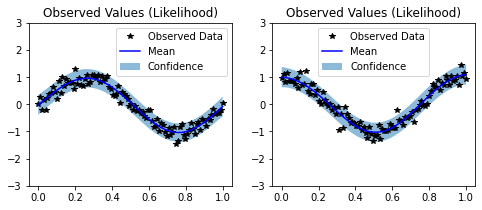

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

## Generating GPFA Data

In [9]:
import numpy as np
n_timepoints = 100
p = 2 # state space dims, 10 in the paper (Yu)
timepoints = torch.linspace(0, 1, 100)
sig_n = 10e-3
sig_f = 1-sig_n
tau = np.random.uniform(size=(p,))

In [12]:
kernel = gpytorch.kernels.RBFKernel(lengthscale=tau)

In [17]:
next(kernel.hyperparameters())

Parameter containing:
tensor([[0.]], requires_grad=True)

In [18]:
tau

array([0.45111222, 0.08063035])